<a href="https://colab.research.google.com/github/kashindra-mahato/Computer-Vision/blob/main/Image_Super_Resolution_using_an_Efficient_Sub_Pixel_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, array_to_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [ ]:
# Load data: BSDS500 dataset
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

In [ ]:
# Create training and validation datasets
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


In [ ]:
def scaling(input_image):
  input_image = input_image / 255.0
  return input_image

In [ ]:
# scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

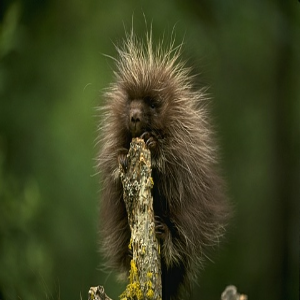

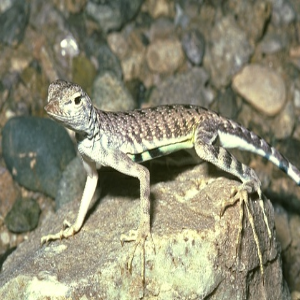

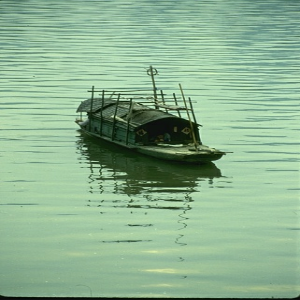

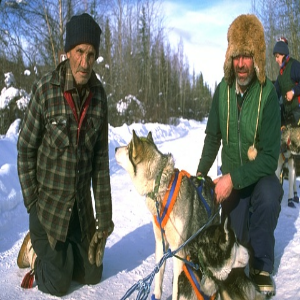

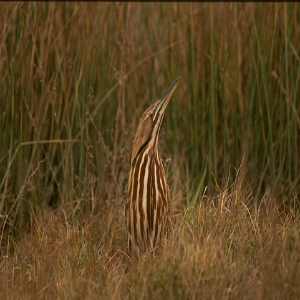

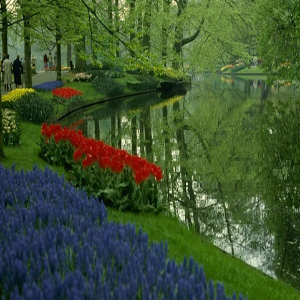

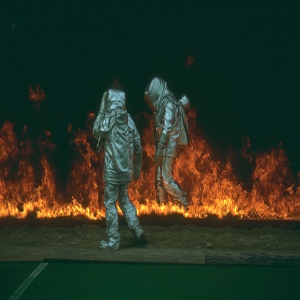

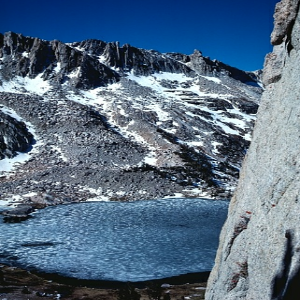

In [ ]:
for batch in train_ds.take(1):
  for img in batch:
    display(array_to_img(img))

In [ ]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

In [ ]:
# Crop and resize images
# Use TF Ops to process
def process_input(input, input_size):
  input = tf.image.rgb_to_yuv(input)
  last_dimension_axis = len(input.shape) - 1
  y, u, v = tf.split(input, 3, axis=last_dimension_axis)
  return tf.image.resize(y, [input_size, input_size], method="area")

In [ ]:
def process_target(input):
  input = tf.image.rgb_to_yuv(input)
  last_dimension_axis = len(input.shape) - 1
  y, u, v = tf.split(input, 3 , axis=last_dimension_axis)
  return y

In [ ]:
train_ds = train_ds.map(
    lambda x: (process_input(x, input_size), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

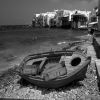

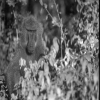

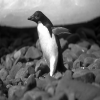

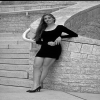

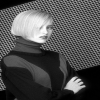

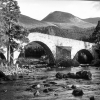

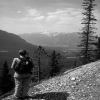

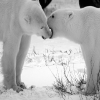

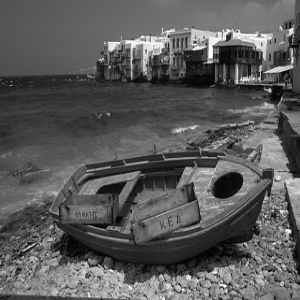

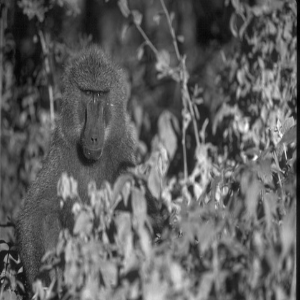

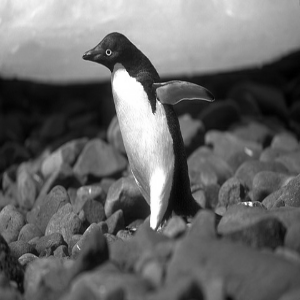

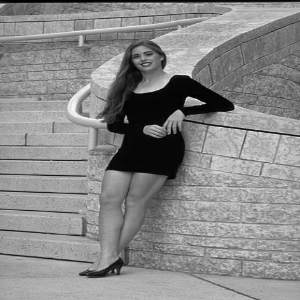

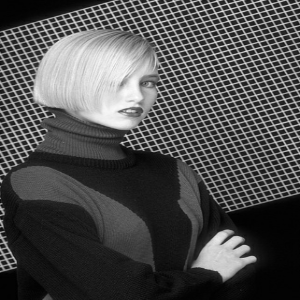

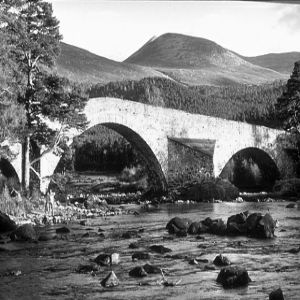

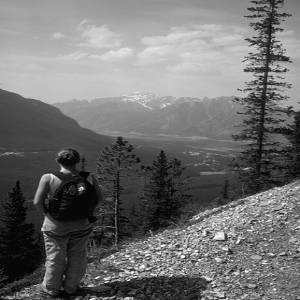

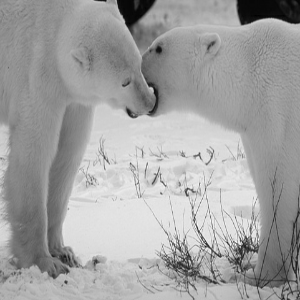

In [ ]:
for batch in train_ds.take(1):
  for img in batch[0]:
    display(array_to_img(img))
  for img in batch[1]:
    display(array_to_img(img))

In [ ]:
# BUild a model
def get_model(upscale_factor=3, channels=1):
  conv_args = {
      "activation": "relu",
      "kernel_initializer": "Orthogonal",
      "padding": "same",
  }
  inputs = keras.Input(shape=(None, None, channels))
  x = layers.Conv2D(64, 5, **conv_args)(inputs)
  x = layers.Conv2D(64, 3, **conv_args)(x)
  x = layers.Conv2D(32, 3, **conv_args)(x)
  x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
  outputs = tf.nn.depth_to_space(x, upscale_factor)

  return keras.Model(inputs, outputs)

In [ ]:
# Define utility functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

In [ ]:
def plot_results(img, prefix, title):
  """ Plot the result with zoom-in area"""
  img_array = img_to_array(img)
  img_array = img_array.astype("float32") / 255.0

  # Create a new figure with a default 111 subplot
  fig, ax = plt.subplots()
  im = ax.imshow(img_array[::-1], origin="lower")

  plt.title(title)
  # zoom-factor: 2.0, location: upper-left
  axins = zoomed_inset_axes(ax, 2, loc=2)
  axins.imshow(img_array[::-1], origin="lower")

  # Specify the limits
  x1, x2, y1, y2 = 200, 300, 100, 200
  # Apply the x-limits
  axins.set_xlim(x1, x2)
  # Apply the y-limits
  axins.set_ylim(y1, y2)

  plt.yticks(visible=False)
  plt.xticks(visible=False)

  #make the line
  mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
  plt.savefig(str(prefix) + "-" + title + ".png")
  plt.show()

In [ ]:
def get_lowres_image(img, upscale_factor):
  """Return low-resolution image to use as model input."""
  return img.resize(
      (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
      PIL.Image.BICUBIC,
  )

def upscale_image(model, img):
  """Predict the result based on input image and restore the image as RGB."""
  ycbcr = img.convert("YCbCr")
  y, cb, cr = ycbcr.split()
  y = img_to_array(y)
  y = y.astype("float32") / 255.0

  input = np.expand_dims(y, axis=0)
  out = model.predict(input)

  out_img_y = out[0]
  out_img_y *= 255.0

  # Restore the image in RGB color space
  out_img_y = out_img_y.clip(0, 255)
  out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
  out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
  out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
  out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
  out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert("RGB")
  return out_img

In [ ]:
# Define callbacks to monitor training
class ESPCNCallback(keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch
    def on_epoch_begin(self, epoch, logs=None):
      self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
      print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
      if epoch % 20 == 0:
        prediction = upscale_image(self.model, self.test_img)
        plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
      self.psnr.append(10 * math.log10(1 / log["loss"]))

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 64)    1664      
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space_1 (TF  (None, None, None, 1)     0         
 OpLambda)                                                       
                                                           

In [ ]:
# Train the model
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)
model.load_weights(checkpoint_filepath)

Epoch 1/100
50/50 - 11s - loss: 0.0318 - val_loss: 0.0059 - 11s/epoch - 217ms/step
Epoch 2/100
50/50 - 3s - loss: 0.0046 - val_loss: 0.0032 - 3s/epoch - 64ms/step
Epoch 3/100
50/50 - 3s - loss: 0.0033 - val_loss: 0.0027 - 3s/epoch - 64ms/step
Epoch 4/100
50/50 - 3s - loss: 0.0030 - val_loss: 0.0026 - 3s/epoch - 70ms/step
Epoch 5/100
50/50 - 2s - loss: 0.0029 - val_loss: 0.0025 - 2s/epoch - 39ms/step
Epoch 6/100
50/50 - 2s - loss: 0.0028 - val_loss: 0.0025 - 2s/epoch - 38ms/step
Epoch 7/100
50/50 - 2s - loss: 0.0029 - val_loss: 0.0025 - 2s/epoch - 38ms/step
Epoch 8/100
50/50 - 2s - loss: 0.0028 - val_loss: 0.0025 - 2s/epoch - 32ms/step
Epoch 9/100
50/50 - 2s - loss: 0.0028 - val_loss: 0.0024 - 2s/epoch - 42ms/step
Epoch 10/100
50/50 - 2s - loss: 0.0028 - val_loss: 0.0024 - 2s/epoch - 36ms/step
Epoch 11/100
50/50 - 2s - loss: 0.0028 - val_loss: 0.0025 - 2s/epoch - 31ms/step
Epoch 12/100
50/50 - 2s - loss: 0.0027 - val_loss: 0.0024 - 2s/epoch - 31ms/step
Epoch 13/100
50/50 - 2s - loss: 0.

1/1 [==============================] - 0s 443ms/step
PSNR of low resolution image and high resolution image is 30.0157
PSNR of predict and high resolution is 30.6857


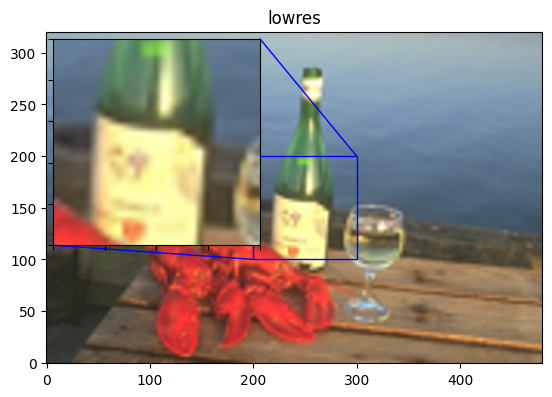

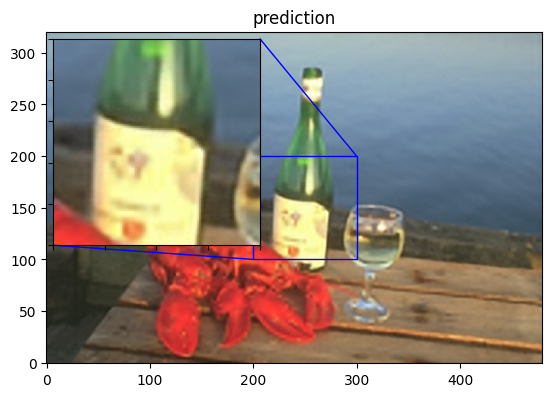

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 25.1103
PSNR of predict and high resolution is 26.1166


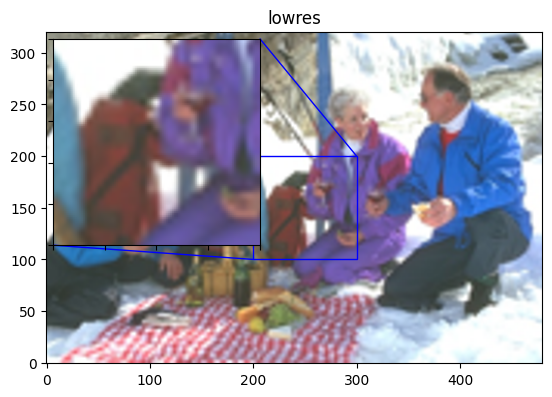

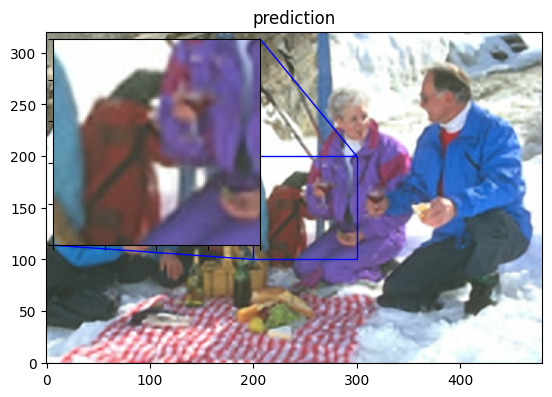

1/1 [==============================] - 0s 286ms/step
PSNR of low resolution image and high resolution image is 27.7789
PSNR of predict and high resolution is 28.4763


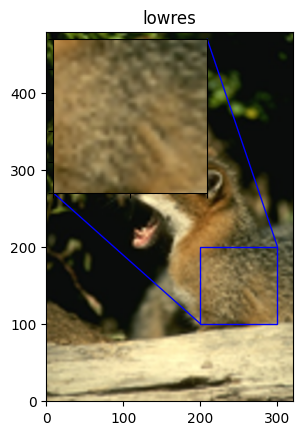

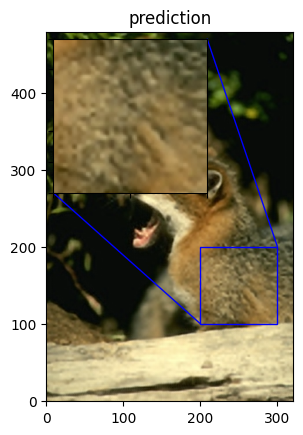

1/1 [==============================] - 0s 29ms/step
PSNR of low resolution image and high resolution image is 28.0321
PSNR of predict and high resolution is 28.3338


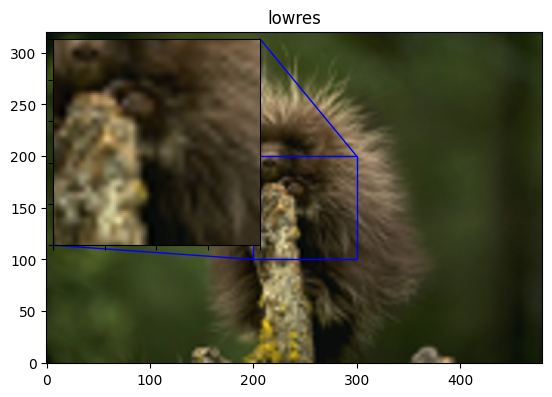

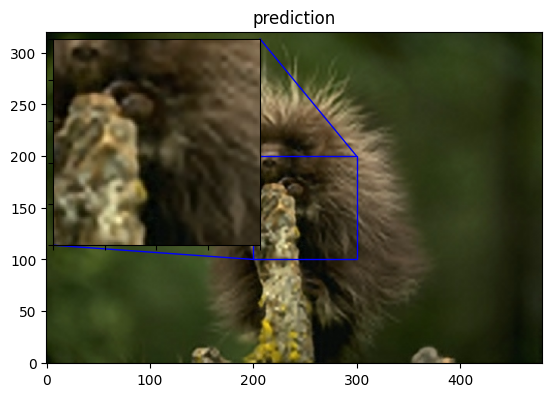

1/1 [==============================] - 0s 22ms/step
PSNR of low resolution image and high resolution image is 25.7853
PSNR of predict and high resolution is 26.3832


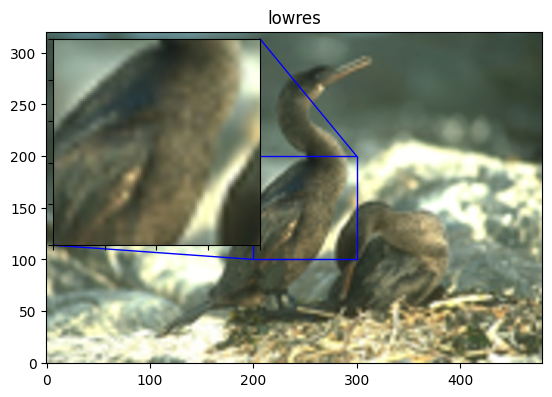

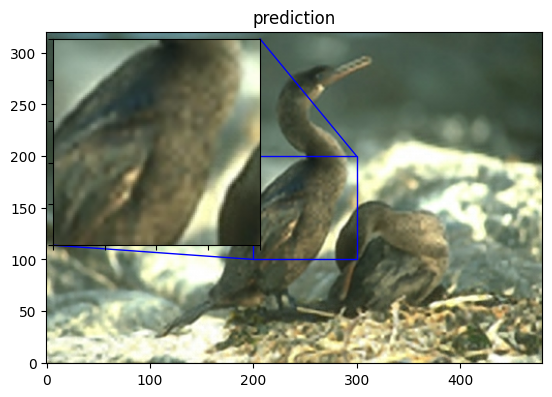

1/1 [==============================] - 0s 35ms/step
PSNR of low resolution image and high resolution image is 25.9181
PSNR of predict and high resolution is 26.7430


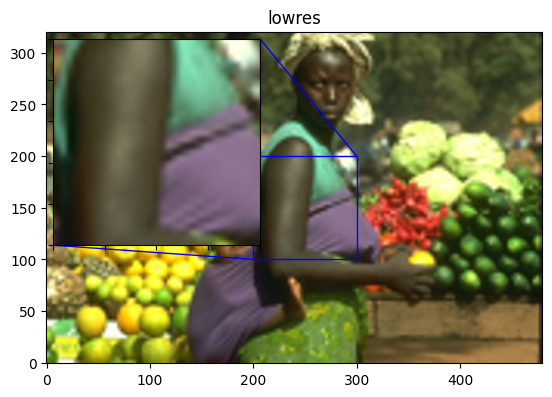

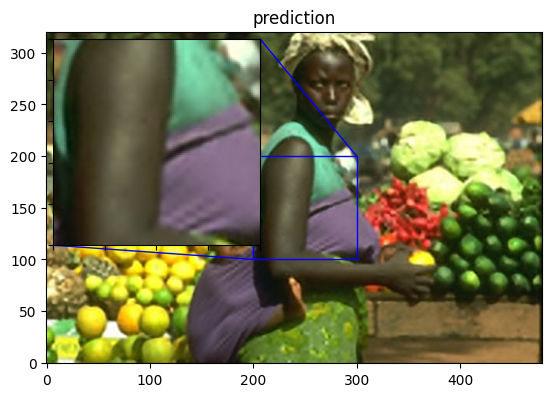

1/1 [==============================] - 0s 33ms/step
PSNR of low resolution image and high resolution image is 26.2389
PSNR of predict and high resolution is 27.1871


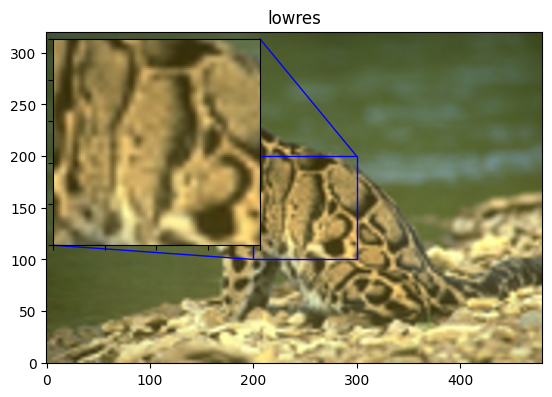

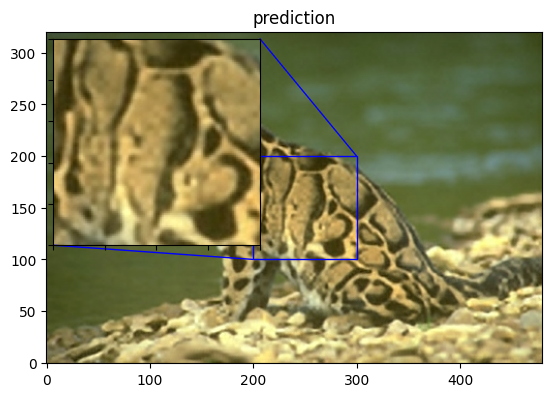

1/1 [==============================] - 0s 31ms/step
PSNR of low resolution image and high resolution image is 23.3281
PSNR of predict and high resolution is 24.6819


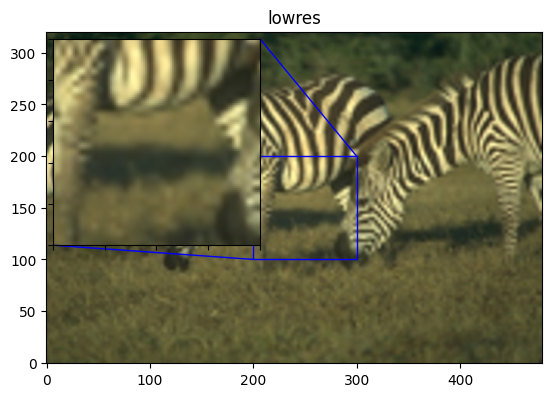

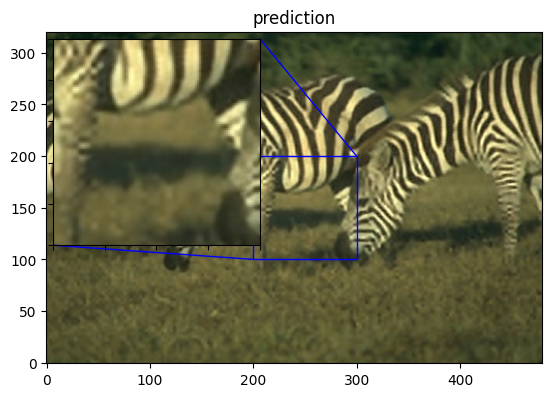

1/1 [==============================] - 0s 36ms/step
PSNR of low resolution image and high resolution image is 29.9008
PSNR of predict and high resolution is 30.1322


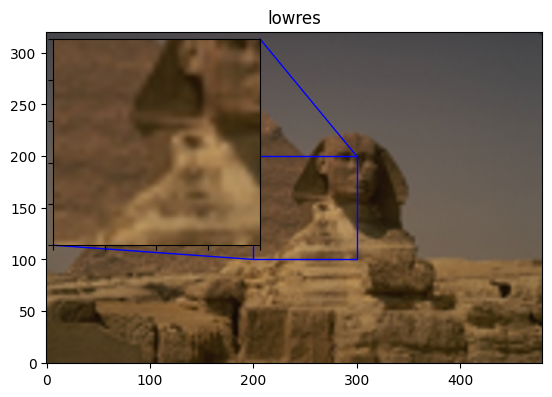

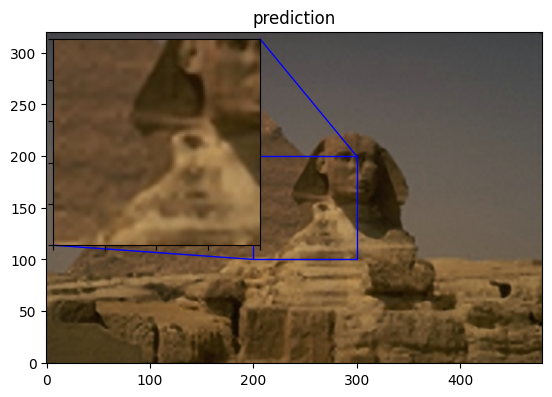

1/1 [==============================] - 0s 60ms/step
PSNR of low resolution image and high resolution image is 25.2492
PSNR of predict and high resolution is 25.8187


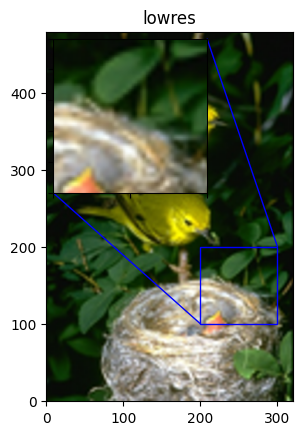

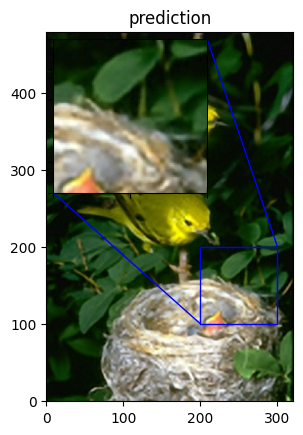

Avg. PSNR of lowres images is 26.7357
Avg. PSNR of reconstructions is 27.4559


In [ ]:
# Run model prediction and plot results
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
  img = load_img(test_img_path)
  lowres_input = get_lowres_image(img, upscale_factor)
  w = lowres_input.size[0] * upscale_factor
  h = lowres_input.size[1] * upscale_factor
  highres_img = img.resize((w, h))
  prediction = upscale_image(model, lowres_input)
  lowres_img = lowres_input.resize((w, h))
  lowres_img_arr = img_to_array(lowres_img)
  highres_img_arr = img_to_array(highres_img)
  predict_img_arr = img_to_array(prediction)
  bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
  test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

  total_bicubic_psnr += bicubic_psnr
  total_test_psnr += test_psnr

  print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
  )
  print("PSNR of predict and high resolution is %.4f" % test_psnr)
  plot_results(lowres_img, index, "lowres")
  # plot_results(highres_img, index, "highres")
  plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))